<a href="https://colab.research.google.com/github/amolkerkar/Music-Genre-Classification/blob/main/Music_Classification_CNN_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import soundfile as sf
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
# from keras.applications.resnet50 import preprocess_input, ResNet50
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# prompt: change present working directory to Mydrive

%cd /content/drive/MyDrive/


/content/drive/MyDrive


In [ ]:
# prompt: list all files in cwd

os.listdir()


['me',
 'Document from amol.pdf',
 'AadharCard.pdf',
 'PanCard.pdf',
 'AMOL_RESUME_ltts.pdf',
 'L & T Trainee Application Form-converted .pdf',
 'cert-1089-21337750.pdf',
 'AmolKerkar-NDG Linux Unhatc-certificate.pdf',
 'Untitled document (1).pdf',
 'insta.mp4',
 'grp pic 1.gdoc',
 'ggrp pic 2.gdoc',
 'IMG-20210616-WA0106.jpg',
 'genesis communication paara.gdoc',
 'Untitled document (5).gdoc',
 'ltts',
 'kalyan villa',
 'kalyan me pics',
 "Raj's mehendi",
 'valorant',
 'SVM Quiz.gdoc',
 'old videos',
 'Guide 5 - Word Problems.pdf',
 'Guide 7 - Reading Comprehension and Essays.pdf',
 'Guide 4 - Number Properties.pdf',
 'Guide 1 - Algebra.pdf',
 'Guide 3 - Geometry.pdf',
 'Guide 2 - Fractions Decimals Percents.pdf',
 'Guide 6 - Data.pdf',
 '5 lb. Book of GRE Practice Problems - Manhattan Prep.pdf',
 'GRE padh vai',
 'Sop.gdoc',
 'CV contents.gdoc',
 'Untitled document (4).gdoc',
 'Ashas lor.gdoc',
 'HODs LOR.gdoc',
 'Asha lor v2.gdoc',
 'list of unis.gdoc',
 'Sop ideas.gdoc',
 'TechExpr

In [ ]:
# prompt: unzip xfiles.zip here

!unzip -o xfiles.zip


Archive:  xfiles.zip
  inflating: X_test.npy              
  inflating: X_train.npy             
  inflating: y_test.npy              
  inflating: y_train.npy             


xtrain --> (35100, 128, 129, 1)
ytrain --> (35100, 10)
xtest --> (3900, 128, 129, 1)
ytest --> (3900, 10)


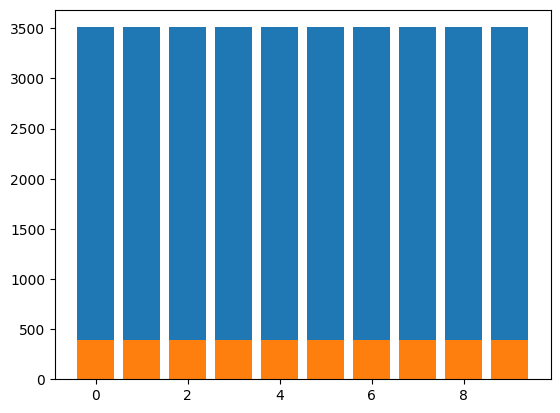

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 129, 16)      160       
                                                                 
 activation (Activation)     (None, 128, 129, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                             

<ipython-input-6-9654ae7bbeba>:122: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/500
142/275 [==============>...............] - ETA: 3:41 - loss: 5.1914 - accuracy: 0.1370

In [ ]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

print('xtrain -->', X_train.shape)
print('ytrain -->',y_train.shape)

print('xtest -->', X_test.shape)


print('ytest -->',y_test.shape)
# #
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

from tensorflow.keras.utils import Sequence

class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size=64, is_test = False):
        self.X = X

        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test

    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))

    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]

        # Apply data augmentation
        if not self.is_test:
            signals = self.__augment(signals)
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]

    def __augment(self, signals, hor_flip = 0.5, random_cutout = 0.5):
        spectrograms =  []
        for s in signals:
            signal = copy(s)

            # Perform horizontal flip
            if np.random.rand() < hor_flip:
                signal = np.flip(signal, 1)

            # Perform random cutoout of some frequency/time
            if np.random.rand() < random_cutout:
                lines = np.random.randint(signal.shape[0], size=2)
                cols = np.random.randint(signal.shape[0], size=3)
                signal[lines, :, :] = -80 # dB
                signal[:, cols, :] = -80 # dB

            spectrograms.append(signal)
        return np.array(spectrograms)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

def conv_block(x, n_filters,filter_size=(3, 3), pool_size=(2, 2),stride=(1, 1)):
    x = Conv2D(n_filters, filter_size, strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=stride)(x)
    x = Dropout(0.4)(x)
    return x

# Model Definition
def create_model(input_shape, num_genres):
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16,stride=(2,2))
    x = conv_block(x, 32,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 64, stride=(2,2))
    x = conv_block(x, 128,filter_size=(3,3),stride=(2,2))
    x = conv_block(x, 256,stride=(2,2))

    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_genres,
                        activation='softmax',
                        kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    model = Model(inputs=inpt, outputs=predictions)
    return model

model = create_model(X_train[0].shape, 10)

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.97,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-10
)

# Generators
batch_size = 128
train_generator = GTZANGenerator(X_train, y_train)
steps_per_epoch = np.ceil(len(X_train)/batch_size)

validation_generator = GTZANGenerator(X_test, y_test)
val_steps = np.ceil(len(X_test)/batch_size)

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=500,
    verbose=1,
    callbacks=[reduceLROnPlat])

# Save the model
model.save('custom_cnn_2610.h5')

